# Implementation of Linear Kalman Filter using Constant Acceleration Motion Model and Linear Measurement Model

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import expm
import scipy.integrate as integrate
from scipy.linalg import sqrtm
import sympy as sp
from sympy import init_printing
init_printing(use_latex=True)
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [2]:
# initalize global variables
dt = 0.01  # seconds
N = 100  # number of samples
qc = 0.1  # process noise magnitude
z_noise = 1  # measurement noise magnitude


## Available sensors:
1. GNSS, measuring x axis position, y axis position
2. Accelerometer, measuring x axis acceleration, y axis acceleration

## Linear Kalman Filter Prediction Step:
1. $x_{k|k-1} = a_{k-1} \cdot x_{k-1|k-1}$
2. $P_{k|k-1} = a_{k-1} \cdot P_{k-1|k-1} \cdot a_{k-1}^T + q_{k-1}$
\
\
In this project, we assume that an object is travelling in a linear path $x=y$, and we obtain noisy measurements of x and y positions from the GNSS sensor. The velocity is assumed to be constant and thus the accelerations would be zero. Hence, the accelerometer would always measure zero acceleration with added noise.

## Linear Kalman Filter Update Step:
1. $k_k = P_{k|k-1} \cdot h_k^T \cdot s_k^{-1}$
2. $v_k = z_k - h_k \cdot x_{k|k-1}$
3. $s_k = h_k \cdot P_{k|k-1} \cdot h_k^T + r_k$
4. $x_{k|k} = x_{k|k-1} + k_{k} \cdot v_{k}$
5. $P_{k|k} = P_{k|k-1} - k_k \cdot s_k \cdot k_k^T$
\
\
In this project, we assume that the state variables - x & y positions and x & y accelerations are directly measurable by the given sensors, with some added noise.

In [3]:
px, py, vx, vy, ax, ay, T = sp.symbols('p_x p_y v_x v_y a_x a_y T')
x_k = sp.Matrix([px, py, vx, vy, ax, ay])
a = sp.Matrix([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
a = sp.exp(T * a)
gamma = sp.Matrix([[0.0], [0.0], [0.0], [0.0], [1.0], [1.0]])
q = qc * gamma @ np.transpose(gamma)
q_euler = T * q
q_exact = sp.integrate(sp.exp(T*a) * q * sp.exp(T*a.T), T)
h = sp.Matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
h_k = sp.Matrix([px, py, ax, ay])

## State Matrix ($x_k$):

In [4]:
x_k

⎡pₓ ⎤
⎢   ⎥
⎢p_y⎥
⎢   ⎥
⎢vₓ ⎥
⎢   ⎥
⎢v_y⎥
⎢   ⎥
⎢aₓ ⎥
⎢   ⎥
⎣a_y⎦

## State Transition Matrix ($a$):

In [5]:
a

⎡                 2        ⎤
⎢1  0  T  0  0.5⋅T     0   ⎥
⎢                          ⎥
⎢                         2⎥
⎢0  1  0  T    0     0.5⋅T ⎥
⎢                          ⎥
⎢0  0  1  0  1.0⋅T     0   ⎥
⎢                          ⎥
⎢0  0  0  1    0     1.0⋅T ⎥
⎢                          ⎥
⎢0  0  0  0   1.0      0   ⎥
⎢                          ⎥
⎣0  0  0  0    0      1.0  ⎦

## Process Noise ($q$):

In [6]:
q_euler

⎡0  0  0  0    0      0  ⎤
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0    0      0  ⎥
⎢                        ⎥
⎢0  0  0  0  0.1⋅T  0.1⋅T⎥
⎢                        ⎥
⎣0  0  0  0  0.1⋅T  0.1⋅T⎦

In [7]:
q_exact

⎡    ⎛        8          7        6        5         4        3         2     
⎢1.0⋅⎝0.0125⋅T  - 0.025⋅T  + 0.1⋅T  - 0.3⋅T  + 0.75⋅T  - 1.5⋅T  + 2.25⋅T  - 2.
⎢                                                                             
⎢    ⎛        8          7        6        5         4        3         2     
⎢1.0⋅⎝0.0125⋅T  - 0.025⋅T  + 0.1⋅T  - 0.3⋅T  + 0.75⋅T  - 1.5⋅T  + 2.25⋅T  - 2.
⎢                                                                             
⎢           ⎛       6         5          4         3          2               
⎢       1.0⋅⎝0.025⋅T  - 0.05⋅T  + 0.125⋅T  - 0.25⋅T  + 0.375⋅T  - 0.375⋅T + 0.
⎢                                                                             
⎢           ⎛       6         5          4         3          2               
⎢       1.0⋅⎝0.025⋅T  - 0.05⋅T  + 0.125⋅T  - 0.25⋅T  + 0.375⋅T  - 0.375⋅T + 0.
⎢                                                                             
⎢                    ⎛       4          3           

## Measurements ($h_k$):

In [8]:
h_k

⎡pₓ ⎤
⎢   ⎥
⎢p_y⎥
⎢   ⎥
⎢aₓ ⎥
⎢   ⎥
⎣a_y⎦

## Measurement Matrix ($h$):

In [9]:
h

⎡1.0  0.0  0.0  0.0  0.0  0.0⎤
⎢                            ⎥
⎢0.0  1.0  0.0  0.0  0.0  0.0⎥
⎢                            ⎥
⎢0.0  0.0  0.0  0.0  1.0  0.0⎥
⎢                            ⎥
⎣0.0  0.0  0.0  0.0  0.0  1.0⎦

In [10]:
# prior mean
x_0 = np.array([[0.0],  # x position
                [0.0],  # y position
                [0.0],  # x velocity
                [0.0],  # y velocity
                [0.0],  # x acceleration
                [0.0]  # y acceleration
                ])

# prior covariance
p_0 = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

# a matrix - discrete time motion model
a = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

a = expm(dt * a)

In [11]:
# q matrix - continuous time process noise covariance
gamma = np.array([[0.0], [0.0], [0.0], [0.0], [1.0], [1.0]])
q = qc * gamma @ np.transpose(gamma)
q_euler = dt * q


# h matrix - measurement model
h = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])


# r matrix - measurement noise covariance
r = np.array([[0.010, 0.0, 0.0, 0.0],
              [0.0, 0.015, 0.0, 0.0],
              [0.0, 0.0, 0.1, 0.0],
              [0.0, 0.0, 0.0, 0.1]])**2

In [12]:
# linear kalman filter
def kalman_filter(x, p, z):
    x_pred, p_pred = linear_prediction(a, x, p, q_euler)
    x_upd, p_upd = linear_update(x_pred, p_pred, z, h, r)
    return x_upd, p_upd

In [13]:
# linear kalman filter prediction step
def linear_prediction(a, x_hat, p_hat, q):
    x_pred = a @ x_hat
    p_pred = a @ p_hat @ np.transpose(a) + q
    return x_pred, p_pred

In [14]:
# linear kalman filter update step
def linear_update(x_hat, p_hat, y, h, r):
    s = h @ p_hat @ np.transpose(h) + r
    k = p_hat @ np.transpose(h) @ np.linalg.pinv(s)
    v = y - h @ x_hat

    x_upd = x_hat + k @ v
    p_upd = p_hat - k @ s @ np.transpose(k)
    return x_upd, p_upd

In [15]:
# generate ground truth position x_true and noisy position z
def gen_measurement(i):
    x_true = np.array([[i], [i], [0.0], [0.0]])
    z = x_true + z_noise * np.random.randn(4, 1)
    return z, x_true

In [17]:
def plot_animation():
    plt.plot(x_true[0], x_true[1], '.r')
    plt.plot(x_est[0], x_est[1], '.b')
    plt.plot(z[0], z[1], '+g')
    plt.grid(True)
    plt.pause(0.001)

In [18]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [19]:
# run the kalman filter
x_est = x_0
p_est = p_0
x_true_cat = np.array([x_0[0, 0], x_0[1, 0]])
x_est_cat = np.array([x_0[0, 0], x_0[1, 0]])
z_cat = np.array([x_0[0, 0], x_0[1, 0]])
for i in range(N):
    z, x_true = gen_measurement(i)
    x_est, p_est = kalman_filter(x_est, p_est, z)
    x_true_cat = np.vstack((x_true_cat, np.transpose(x_true[0:2])))
    z_cat = np.vstack((z_cat, np.transpose(z[0:2])))
    x_est_cat = np.vstack((x_est_cat, np.transpose(x_est[0:2])))
print('KF Over')

KF Over


## Ground Truth Trajectory, Noisy Measurements, Estimated Trajectory: 

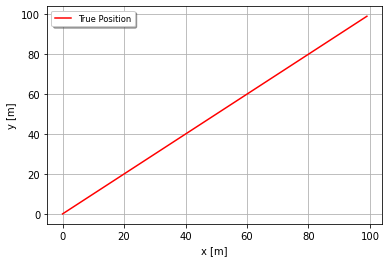

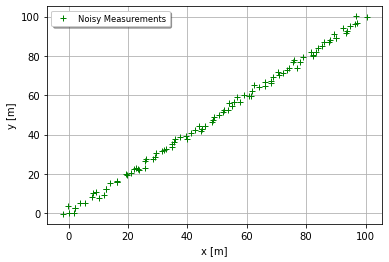

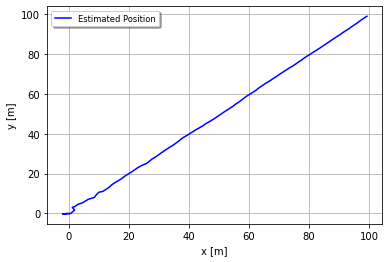

In [21]:
fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_true_cat[0:, 0], x_true_cat[0:, 1], 'r', label='True Position')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

fig = plt.figure()
f = fig.add_subplot(111)
f.plot(z_cat[0:, 0], z_cat[0:, 1], '+g', label='Noisy Measurements')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_est_cat[0:, 0], x_est_cat[0:, 1], 'b', label='Estimated Position')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)

plt.show()

## Final Output:

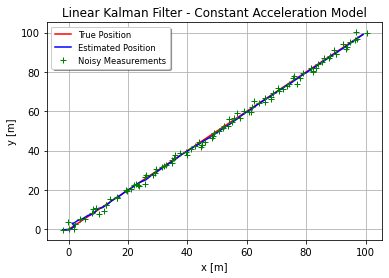

In [22]:
fig = plt.figure()
f = fig.add_subplot(111)
f.plot(x_true_cat[0:, 0], x_true_cat[0:, 1], 'r', label='True Position')
f.plot(x_est_cat[0:, 0], x_est_cat[0:, 1], 'b', label='Estimated Position')
f.plot(z_cat[0:, 0], z_cat[0:, 1], '+g', label='Noisy Measurements')
f.set_xlabel('x [m]')
f.set_ylabel('y [m]')
f.set_title('Linear Kalman Filter - Constant Acceleration Model')
f.legend(loc='upper left', shadow=True, fontsize='small')
plt.grid(True)
plt.show()